# 1. 이미지 파일경로 불러오기

In [125]:
import os
import torch
import cv2
import copy
from torch import nn
import matplotlib.pyplot as plt
from ipywidgets import interact

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

In [126]:
# 이미지 파일경로를 리스트로 받아오는 함수(폴더 이름label도 같이 불러오기 위함)

def list_image_files(data_dir, sub_dir):
    img_list = []
    img_dir = os.path.join(data_dir, sub_dir)

    for file in os.listdir(img_dir):
        img_list.append(sub_dir+'/'+file)
    
    return img_list

In [127]:
data_dir = "../data/MEDICAL-DATASET/Classification/train/"

Normal_list = list_image_files(data_dir,"Normal")
Covid_list = list_image_files(data_dir,"Covid")
Viral_list = list_image_files(data_dir,"Viral Pneumonia")


# 2. 이미지데이터 확인

In [128]:
print(len(Normal_list), len(Covid_list), len(Viral_list))

70 111 70


In [129]:
# 데이터 RGB로 받아오는 함수
def get_RGB(data_dir, file_name):
    img_dir = os.path.join(data_dir, file_name)
    img = cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB)

    return img

In [130]:
min_data = min(len(Normal_list), len(Covid_list), len(Viral_list))

# img그려주는 함수
@interact(index=(0,min_data-1))
def show_sample(index=0):
    Normal_img = get_RGB(data_dir, Normal_list[index])
    Covid_img = get_RGB(data_dir, Covid_list[index])
    Viral_img = get_RGB(data_dir, Viral_list[index])

    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(Normal_img)
    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(Covid_img)
    plt.subplot(133)
    plt.title('Viral')
    plt.imshow(Viral_img) 
    plt.tight_layout() #그림의 여백을 최적화
    
          

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 3. 데이터셋 구축

### 데이터셋 구축의 과정
##### 5.1 데이터 셋을 로드하는 클래스 구축
##### 5.2 데이터를 텐서형으로 변환
##### 5.3 이터레이터 기능을 하는 데이터 로더를 생성

In [131]:
class_list = ["Normal", "Covid", "Viral Pneumonia"]

In [132]:
# 데이터셋 클래스 구현
# init, len, getitem이 구현되어야함

class My_Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.class_list = ["Normal", "Covid", "Viral Pneumonia"]
        self.data_dir = data_dir
        Normal_list = list_image_files(self.data_dir,"Normal")
        Covid_list = list_image_files(self.data_dir,"Covid")
        Viral_list = list_image_files(self.data_dir,"Viral Pneumonia")
        

        self.all_data_list = Normal_list+Covid_list+Viral_list
        self.transform = transform 

    def __len__(self):
        return len(self.all_data_list)

    def __getitem__(self, index): #RGB데이터와 label불러줌
        img = get_RGB(self.data_dir, self.all_data_list[index])
        label = self.class_list.index(self.all_data_list[index].split('/')[0])

        if self.transform:
            img = self.transform(img) # 이미지를 텐서로 바꿔주는부분
            label = torch.Tensor([label]).long() #레이블을 텐서로 바꿔주는 부분
        
        return {'img':img, 'label':label}
        


In [133]:
data_set = My_Dataset(data_dir)

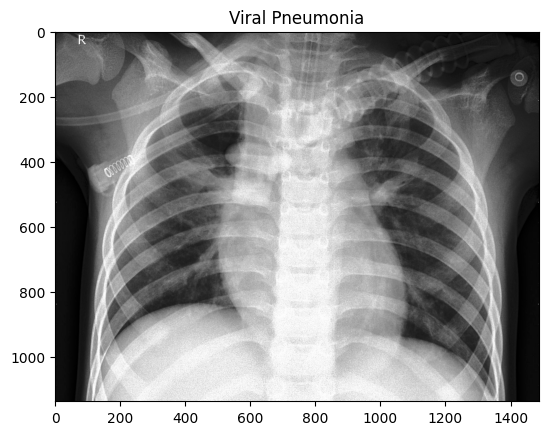

In [134]:
index = 200
plt.title(class_list[data_set[index]['label']])
plt.imshow(data_set[index]['img'])

# 4.텐서형태로 변환

In [135]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5])])

In [136]:
# 변환 결과 확인
tdata_set = My_Dataset(data_dir, transformer)
img = tdata_set[100]['img']
label = tdata_set[100]['label']

print(img.shape, label)

torch.Size([3, 224, 224]) tensor([1])


# 5. 데이터 로더 구현

In [165]:
# train과 val데이터를 딕셔너리로 묶어서 데이터 로더 생성
# test Data도 label을 알고있어서 같이 구현

def My_Dataloader(train_dir, test_dir):
    dataloader = {}
    train_dataset = My_Dataset(train_dir,transformer)
    
    # 학습 데이터와 검증 데이터로 분할
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    dataloader['train'] = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
    dataloader['val'] = DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=False)
    

    test_dataset = My_Dataset(test_dir, transformer)
    dataloader['test'] = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

    return dataloader

In [166]:
data_dir

'../data/MEDICAL-DATASET/Classification/train/'

In [167]:
train_dir = '../data/MEDICAL-DATASET/Classification/train/'
test_dir = '../data/MEDICAL-DATASET/Classification/test/'

dataloader = My_Dataloader(train_dir, test_dir)

# 6. VGG 모델 fine-tuning 

In [140]:
model = models.vgg19(pretrained=True)

In [141]:
from torchsummary import summary
summary(model,(3,224,224),batch_size=4,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 224, 224]           1,792
              ReLU-2          [4, 64, 224, 224]               0
            Conv2d-3          [4, 64, 224, 224]          36,928
              ReLU-4          [4, 64, 224, 224]               0
         MaxPool2d-5          [4, 64, 112, 112]               0
            Conv2d-6         [4, 128, 112, 112]          73,856
              ReLU-7         [4, 128, 112, 112]               0
            Conv2d-8         [4, 128, 112, 112]         147,584
              ReLU-9         [4, 128, 112, 112]               0
        MaxPool2d-10           [4, 128, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]         295,168
             ReLU-12           [4, 256, 56, 56]               0
           Conv2d-13           [4, 256, 56, 56]         590,080
             ReLU-14           [4, 256,

In [142]:
# FC layer를 변경
model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 기존의 7,7로 반환되던 avgpool층을 1,1로 반환되도록 변경
model.classifier = nn.Sequential( #분류기에 접근 할 때 이 방법도 사용 가능
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256,len(class_list)),
    nn.Softmax()
)

In [143]:
summary(model,(3,224,224),batch_size=4,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 224, 224]           1,792
              ReLU-2          [4, 64, 224, 224]               0
            Conv2d-3          [4, 64, 224, 224]          36,928
              ReLU-4          [4, 64, 224, 224]               0
         MaxPool2d-5          [4, 64, 112, 112]               0
            Conv2d-6         [4, 128, 112, 112]          73,856
              ReLU-7         [4, 128, 112, 112]               0
            Conv2d-8         [4, 128, 112, 112]         147,584
              ReLU-9         [4, 128, 112, 112]               0
        MaxPool2d-10           [4, 128, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]         295,168
             ReLU-12           [4, 256, 56, 56]               0
           Conv2d-13           [4, 256, 56, 56]         590,080
             ReLU-14           [4, 256,

# 7. 손실함수

In [144]:
loss_func = nn.CrossEntropyLoss(reduction='mean') #reduction='mean' : 배치사이즈에 따른 평균값을 구함

# 8. Gradient최적화 함수

In [145]:
# 변경된 부분만 학습
optimizer = torch.optim.SGD([
                            {'params': model.avgpool.parameters(), 'lr':0.001},
                            {'params': model.classifier.parameters(), 'lr':0.001}],momentum=0.9)

# 9. 모델 학습을 위한 함수

In [146]:
device = torch.device('cpu')

def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses={} #한 에폭에서의 평균 loss를 담을 것
    accuracy={} #한 에폭에서의 평균 정확도를 담을 것

    for ty in ['train','val']:
        running_loss = 0.0
        running_correct = 0
        
        if ty == 'train':
            model.train()
        else :
            model.eval()

        for index, batch in enumerate(dataloaders[ty]):
            img = batch['img'].to(device)
            label = batch['label'].squeeze(dim=1).to(device)
        
            with torch.set_grad_enabled(ty=='train'): #train인 경우에만 grad를 갱신
                predict = model(img)
                loss = loss_func(predict, label)
        
                _, pred_label = torch.max(predict, dim=1) #predict shape이 (Batch_size, 3_label개수) 이기 때문에 각 label중 최대값만 찾기 위함
                is_correct = (pred_label==label).numpy().sum()/len(label) # 정확도: 맞은개수/전체개수
        
                if ty=='train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        
                running_loss+=loss.item() # 배치별 평균 loss의 합
                running_correct += is_correct # 배치별 평균 정확도의 합
        
                if ty=='train':
                    if index%10==0:
                        print(f"{index}/{len(dataloaders[ty])} 의 batch loss : {loss.item()}")

        losses[ty] = running_loss/len(dataloaders[ty]) #에폭당 평균 loss
        accuracy[ty] = running_correct/len(dataloaders[ty]) #에폭당 평균 정확도


    return losses, accuracy       


In [147]:
def save_best_model(model_state, model_name, save_dir='./trained_model'):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

# 10. 모델 학습

In [148]:
num_epochs = 2
best_acc = 0.0
train_loss, train_acc = [],[] # 그래프 그리기 위해서 에폭당 손실, 정확도를 담음
val_loss, val_acc = [],[]

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloader, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_acc.append(accuracies['train'])
    val_acc.append(accuracies['val'])

    print(f"{epoch+1}/{num_epochs}-Train Loss: {losses['train']}, Val Loss: {losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc: {accuracies['train']}, Val Acc: {accuracies['val']}")

    if accuracies['val'] > best_acc:
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict())
        best_model_epoch = epoch

save_best_model(best_model, f'best_model_{best_model_epoch}')
print(f"Best Accuracy: {best_acc}")        

    

0/50 의 batch loss : 1.0958795547485352
10/50 의 batch loss : 1.102729082107544
20/50 의 batch loss : 1.0783525705337524
30/50 의 batch loss : 1.0694166421890259
40/50 의 batch loss : 1.0984840393066406
1/2-Train Loss: 1.0890277791023255, Val Loss: 1.074732413658729
1/2-Train Acc: 0.51, Val Acc: 0.5256410256410257
0/50 의 batch loss : 1.0951036214828491
10/50 의 batch loss : 1.091199517250061
20/50 의 batch loss : 1.0424712896347046
30/50 의 batch loss : 1.1265352964401245
40/50 의 batch loss : 1.0775222778320312
2/2-Train Loss: 1.0698079800605773, Val Loss: 1.0524269479971666
2/2-Train Acc: 0.45, Val Acc: 0.5256410256410257
Best Accuracy: 0.5256410256410257


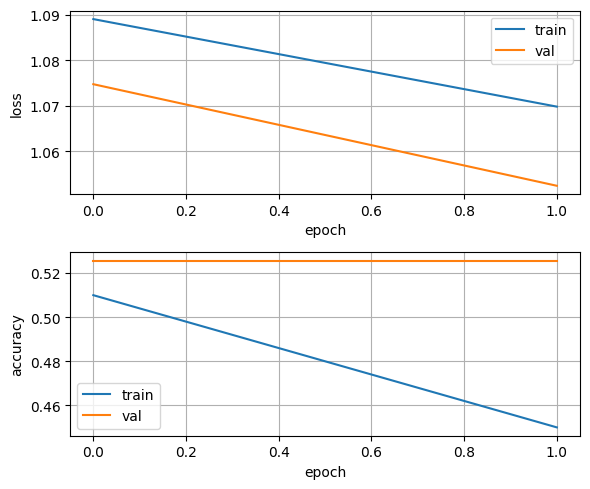

In [149]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_acc, label="train")
plt.plot(val_acc, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.tight_layout()

# 11. test

In [189]:
# 모델 예측값 
pred = []
for index, batch in enumerate(dataloader['test']):
    img = batch['img']
    label = batch['label']
    
    predict = model(img)
    _, pred_label = torch.max(predict, dim=1)
    pred.append(pred_label.item())

In [190]:
# 정답 label
test_dataset = My_Dataset(test_dir)
label = []
for i in range(len(test_dataset)):
    label.append(test_dataset[i]['label'])

In [192]:
# 두 list비교 
accuracy = np.mean(np.array(pred) == np.array(label))
print(accuracy)

0.4696969696969697
